In [3]:
!pip install cvxpy

  Using cached cvxpy-1.7.3-cp311-cp311-macosx_10_9_universal2.whl.metadata (9.5 kB)
  Using cached clarabel-0.11.1-cp39-abi3-macosx_11_0_arm64.whl.metadata (4.8 kB)
  Using cached cffi-2.0.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.6 kB)
Using cached cvxpy-1.7.3-cp311-cp311-macosx_10_9_universal2.whl (1.5 MB)
Using cached clarabel-0.11.1-cp39-abi3-macosx_11_0_arm64.whl (935 kB)
Using cached cffi-2.0.0-cp311-cp311-macosx_11_0_arm64.whl (180 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [cvxpy]32m2/3 [cvxpy]


(CVXPY) Nov 09 04:31:05 PM: Your problem has 450 variables, 900 constraints, and 0 parameters.
(CVXPY) Nov 09 04:31:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 09 04:31:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 09 04:31:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 09 04:31:05 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 09 04:31:05 PM: Compiling problem (target solver=OSQP).
(CVXPY) Nov 09 04:31:05 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Nov 09 04:31:05 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 09 04:31:05 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Nov 09 04:31:05 PM: Applying reduction QpMatrixStuffing
(CVXPY) Nov 09 04:31:05 PM: Applying reduction OSQP
(CVXPY) Nov 09 04:31:05 PM: Finished problem compilation 

                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 450, constraints m = 900
          nnz(P) + nnz(A) = 101925
settings: algebra = Built-in,
          OSQPIn

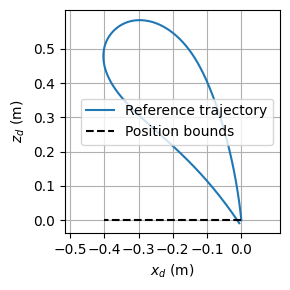

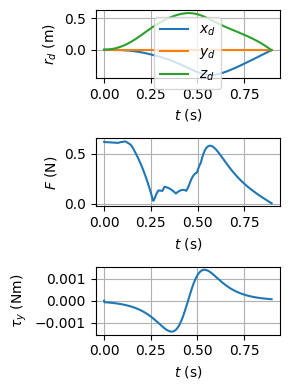

In [4]:
import numpy as np
import sympy as sp
from scipy.linalg import expm
import cvxpy as cp
import matplotlib.pyplot as plt

# ============================================================
# Parameters of the Crazyflie 2.1
# ============================================================

m = 0.028
g = 9.81
L = 0.046 / np.sqrt(2)
J = np.diag([1.4e-5, 1.4e-5, 2.17e-5])
N = 450
f_max = 0.64

# ============================================================
# Reference trajectory for R
# ============================================================

t = sp.Symbol('t', real=True)
q_expr = -1.9999 / (1 + sp.exp(-20 * (t - 0.45))) + 1.9999 / 2
dq_expr = sp.diff(q_expr, t)
q_func = sp.lambdify(t, q_expr, 'numpy')
dq_func = sp.lambdify(t, dq_expr, 'numpy')

T = np.linspace(0, 0.9, N)
q0 = q_func(T)
dq0 = dq_func(T)

R33 = np.zeros(N)
R13 = np.zeros(N)
R = np.zeros((N, 3, 3))
w = np.zeros((N, 3))
dw = np.zeros((N, 3))
eul = np.zeros((N, 3))

def quat_to_rotm(q):
    """Quaternion to rotation matrix (scalar-first, [w, x, y, z])."""
    w, x, y, z = q
    R = np.array([
        [1 - 2*(y**2 + z**2),     2*(x*y - z*w),     2*(x*z + y*w)],
        [2*(x*y + z*w), 1 - 2*(x**2 + z**2),         2*(y*z - x*w)],
        [2*(x*z - y*w),     2*(y*z + x*w), 1 - 2*(x**2 + y**2)]
    ])
    return R

for i in range(N):
    q = [q0[i], 0, np.sqrt(max(0, 1 - q0[i]**2)), 0]
    R[i, :, :] = quat_to_rotm(q)
    eul[i, 1] = np.arcsin(2*(q[0]*q[2] - q[1]*q[3]))  # pitch (approx.)
    R33[i] = R[i, 2, 2]
    R13[i] = R[i, 0, 2]
    w[i, 1] = 2 * dq0[i] / np.sqrt(max(1e-8, 1 - q0[i]**2))
    if i > 0:
        dw[i, 1] = (w[i, 1] - w[i - 1, 1]) * N / 0.9

tau = np.zeros(N)
for i in range(N):
    tau[i] = (J @ dw[i, :]) @ np.array([0, 1, 0])

# ============================================================
# Quadratic program setup
# ============================================================

Ts = 0.9 / N
Ac = np.array([[0, 1, 0, 0],
               [0, 0, 0, 0],
               [0, 0, 0, 1],
               [0, 0, 0, 0]])

B = np.zeros((4, N))
for i in range(N):
    Bc = np.array([[0], [R13[i]/m], [0], [R33[i]/m]])
    Mexp = expm(np.block([[Ac, Bc], [np.zeros((1, 5))]]) * Ts)
    B[:, i] = Mexp[:4, 4]
A = Mexp[:4, :4]

M = np.zeros((4, N))
x = np.zeros((4, N))
xr = np.array([[0], [0], [0.5 * g * (Ts * N)**2], [0]])  # final state reference

for i in range(N - 1):
    M[:, i] = np.linalg.matrix_power(A, N - i) @ B[:, i]

Q = np.array([[1, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 0]])

f_vec = (x[:, 0].T @ np.linalg.matrix_power(A, N).T @ Q @ M - xr.T @ M).flatten()
H = M.T @ Q @ M

# ============================================================
# Constraints
# ============================================================

D = np.zeros((2*N, N))
d = np.zeros(2*N)
for i in range(N):
    D[2*i, i] = -1
    d[2*i] = -abs(tau[i]) / L
    D[2*i+1, i] = 1
    d[2*i+1] = f_max - abs(tau[i]) / L

# Position constraints
xmin, xmax = 0.0, 0.5
zmin, zmax = -0.05, 0.5
e = np.tile(np.array([xmax, 0, zmax, 0, -xmin, 0, -zmin, 0]), N)
for i in range(N):
    e[8*i+2] += 0.5 * g * (i * Ts)**2
    e[8*i+6] -= 0.5 * g * (i * Ts)**2

# ============================================================
# Solve Quadratic Program using CVXPY
# ============================================================

u = cp.Variable(N)
objective = 0.5 * cp.quad_form(u, H) + f_vec @ u
constraints = [D @ u <= d]
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve(verbose=True)

u_val = u.value

# ============================================================
# Propagate state
# ============================================================

for i in range(N - 1):
    x[:, i + 1] = A @ x[:, i] + B[:, i] * u_val[i]

for i in range(N):
    x[2, i] -= 0.5 * g * (i * Ts)**2

time = np.arange(N) / 500
pitch = eul[:, 1]

# ============================================================
# Plots
# ============================================================

plt.figure(figsize=(3, 3))
plt.plot(-x[0, :], x[2, :])
plt.plot([0, -0.4], [0, 0], 'k--')
plt.axis([-0.55, 0.03, -0.07, 0.55])
plt.xticks(np.arange(-0.5, 0.1, 0.1))
plt.yticks(np.arange(0, 0.6, 0.1))
plt.axis('equal')
plt.xlabel(r'$x_d$ (m)')
plt.ylabel(r'$z_d$ (m)')
plt.legend(['Reference trajectory', 'Position bounds'])
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(3, 4))
plt.subplot(3, 1, 1)
plt.plot(time, -x[0, :], label='$x_d$')
plt.plot(time, np.zeros_like(time), label='$y_d$')
plt.plot(time, x[2, :], label='$z_d$')
plt.xlabel('$t$ (s)')
plt.ylabel('$r_d$ (m)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time[:-1], u_val[:-1])
plt.xlabel('$t$ (s)')
plt.ylabel('$F$ (N)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, tau)
plt.xlabel('$t$ (s)')
plt.ylabel(r'$\tau_y$ (Nm)')
plt.grid(True)
plt.tight_layout()
plt.show()
